In [1]:
import os
import pandas as pd
from bert_score import score

def compute_bertscore(
    df: pd.DataFrame,
    reference_col: str,
    hypothesis_col: str,
    question_id_col: str,
    language: str,
    output_csv_path: str,
    mean_csv_path=None
) -> pd.DataFrame:
    """
    Computes BERTScore for each row in `df`, comparing `hypothesis_col` to
    `reference_col` in the specified `language`. Stores the row-level 
    precision, recall, and F1 in a DataFrame, and writes it to `output_csv_path`.
    
    Args:
        df (pd.DataFrame): DataFrame containing references & hypotheses
        reference_col (str): Name of the column with reference/human texts
        hypothesis_col (str): Name of the column with system/hypothesis texts
        question_id_col (str): Name of the column with question IDs
        language (str): Language code for BERTScore ("en", "de", etc.)
        output_csv_path (str): Path to save the resulting DataFrame
        mean_eval_path (str): Path to save the mean evaluation results

    Returns:
        pd.DataFrame: DataFrame containing row-level BERTScore P, R, F1
    """
    # Convert references/hypotheses to lists
    references = df[reference_col].astype(str).tolist()
    hypotheses = df[hypothesis_col].astype(str).tolist()
    
    # Ensure matching lengths
    assert len(references) == len(hypotheses), "Mismatch in # of references vs. hypotheses"
    
    # Run BERTScore
    (P, R, F1), bert_hash = score(
        cands=hypotheses, 
        refs=references, 
        lang=language,
        verbose=True,
        return_hash=True
    )
    
    # Build results DataFrame
    bert_df = pd.DataFrame()
    bert_df[question_id_col] = df[question_id_col].values
    bert_df['BERTScore_P'] = P.tolist()
    bert_df['BERTScore_R'] = R.tolist()
    bert_df['BERTScore_F1'] = F1.tolist()

    # Print system-level (macro) F1
    system_f1_mean = bert_df['BERTScore_F1'].mean()
    print(f"[{language.upper()}] System-level BERTScore F1: {system_f1_mean:.3f}")
    print(f"[{language.upper()}] BERTScore hash code: {bert_hash}\n")

    # Save to CSV
    bert_df.to_csv(output_csv_path, index=False, quoting=1)
    print(f"BERTScore results saved to: {output_csv_path}")

    if mean_csv_path is not None and os.path.exists(mean_csv_path) and language is not None:
        # save the mean evaluation scores
        mean_eval = pd.read_csv(mean_csv_path)
        # add row to the mean_eval df
        if f"BERTScore_F1_{language}" not in mean_eval["metric"].values:
            mean_eval = pd.concat([mean_eval, pd.DataFrame([{"metric": f"BERTScore_F1_{language}", "value": system_f1_mean}])], ignore_index=True)
        mean_eval.to_csv(mean_csv_path, index=False)

    return bert_df

# 1. Load the data
cwd = os.getcwd()
    
csv_path_de = os.path.join(cwd, '../../data/final_merged_dataset_short_de.csv')
csv_path_en = os.path.join(cwd, '../../data/final_merged_dataset_short_en.csv')
mean_csv_path = os.path.join(cwd, '../../data/eval/mean_eval.csv')
    
df_de = pd.read_csv(csv_path_de)
df_en = pd.read_csv(csv_path_en)

# 2. (Optional) limit for demonstration
df_de = df_de.head(18).copy()
df_en = df_en.head(18).copy()

# 3. Compute BERTScore for German
output_csv_de = os.path.join(cwd, '../../data/eval/bertscore_evaluation_de.csv')
bert_df_de = compute_bertscore(
    df=df_de,
    reference_col='human_answer_de',
    hypothesis_col='chatbot_answer_de',
    question_id_col='question_id_q',
    language='de',  # BERTScore language code
    output_csv_path=output_csv_de,
    mean_csv_path=mean_csv_path
)

# 4. Compute BERTScore for English
output_csv_en = os.path.join(cwd, '../../data/eval/bertscore_evaluation_en.csv')
bert_df_en = compute_bertscore(
    df=df_en,
    reference_col='human_answer_en',
    hypothesis_col='chatbot_answer_en',
    question_id_col='question_id_q',
    language='en',
    output_csv_path=output_csv_en,
    mean_csv_path=mean_csv_path
)

# If you want a single CSV, merge them on 'question_id_q' similarly to BLEU/ROUGE:
# merged_bert_df = pd.merge(bert_df_de, bert_df_en, on='question_id_q', suffixes=('_de', '_en'))
# merged_bert_path = os.path.join(cwd, 'data/eval/bertscore_evaluation_de_en.csv')
# merged_bert_df.to_csv(merged_bert_path, index=False, quoting=1)
# print("Merged BERTScore results saved to:", merged_bert_path)


/home/marvin/venv/bertscore_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00,  5.61it/s]


done in 2.71 seconds, 6.65 sentences/sec
[DE] System-level BERTScore F1: 0.669
[DE] BERTScore hash code: bert-base-multilingual-cased_L9_no-idf_version=0.3.12(hug_trans=4.47.1)

BERTScore results saved to: /mnt/c/Users/wurch/Documents/_STUDIUM/Cognitive_Science_Studium/_thesis/Assessing-Answer-Accuracy-Hallucination-and-Document-Relevance-in-a-RAG-Based-Chatbot/code/eval/../../data/eval/bertscore_evaluation_de.csv


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:06<00:00,  6.53s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 37.59it/s]

done in 6.56 seconds, 2.74 sentences/sec
[EN] System-level BERTScore F1: 0.852
[EN] BERTScore hash code: roberta-large_L17_no-idf_version=0.3.12(hug_trans=4.47.1)

BERTScore results saved to: /mnt/c/Users/wurch/Documents/_STUDIUM/Cognitive_Science_Studium/_thesis/Assessing-Answer-Accuracy-Hallucination-and-Document-Relevance-in-a-RAG-Based-Chatbot/code/eval/../../data/eval/bertscore_evaluation_en.csv


In [1]:
import pandas as pd
import os
from bert_score import score

# 1. Load the data
cwd = os.getcwd()
csv_path = os.path.join(cwd, 'data/final_merged_dataset_short.csv')
df_original = pd.read_csv(csv_path)

# 2. Get a subset or copy the entire DataFrame with answers
df = df_original.head(18).copy()

# 3. Extract sequences for comparison
human_answers_refs = df['human_answer'].astype(str).tolist()
chatbot_answers_cands = df['chatbot_answer'].astype(str).tolist()

# Ensure the lists match in length
assert len(human_answers_refs) == len(chatbot_answers_cands), "Mismatch in lengths."

# # sanity check
# P, R, F1 = score(['mal schauen ob dies f1 von 1 ergibt'], ['mal schauen ob dies f1 von 1 ergibt'], lang="de", verbose=True)
# print(F1)

# 4. Compute BERTScore
# Note: For the first run, it downloads the 'bert-base-multilingual-cased' model
(P, R, F1), bert_hash = score(
    chatbot_answers_cands, 
    human_answers_refs, 
    lang="de", 
    verbose=True, 
    return_hash=True
)

# 5. Create a new DataFrame for BERTScore results
bert_df = pd.DataFrame()

# Keep question_id_q
bert_df['question_id_q'] = df['question_id_q'].values

# Convert P, R, F1 tensors to lists so they can be stored in a DataFrame
bert_df['BERTScore_P'] = P.tolist()
bert_df['BERTScore_R'] = R.tolist()
bert_df['BERTScore_F1'] = F1.tolist()

# 6. Print system-level (macro) F1
system_f1_mean = bert_df['BERTScore_F1'].mean()
print(f"System-level BERTScore F1: {system_f1_mean:.3f}")

# 7. Print hash code for reference
print(f"Hash code: {bert_hash}")

# 8. Save the new DataFrame to CSV
output_csv_path = os.path.join(cwd, 'data/eval/bertscore_evaluation_de.csv')
bert_df.to_csv(output_csv_path, index=False)
print("BERTScore results saved to:", output_csv_path)


/home/marvin/venv/bertscore_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.60s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


done in 2.81 seconds, 6.40 sentences/sec
System-level BERTScore F1: 0.685
Hash code: bert-base-multilingual-cased_L9_no-idf_version=0.3.12(hug_trans=4.47.1)
BERTScore results saved to: /mnt/c/Users/wurch/Documents/_STUDIUM/Cognitive_Science_Studium/_thesis/Assessing-Answer-Accuracy-Hallucination-and-Document-Relevance-in-a-RAG-Based-Chatbot/data/eval/bertscore_evaluation_de.csv


Saved figure to file:  /mnt/c/Users/wurch/Documents/_STUDIUM/Cognitive_Science_Studium/_thesis/Assessing-Answer-Accuracy-Hallucination-and-Document-Relevance-in-a-RAG-Based-Chatbot/data/eval/bert_score_example.png


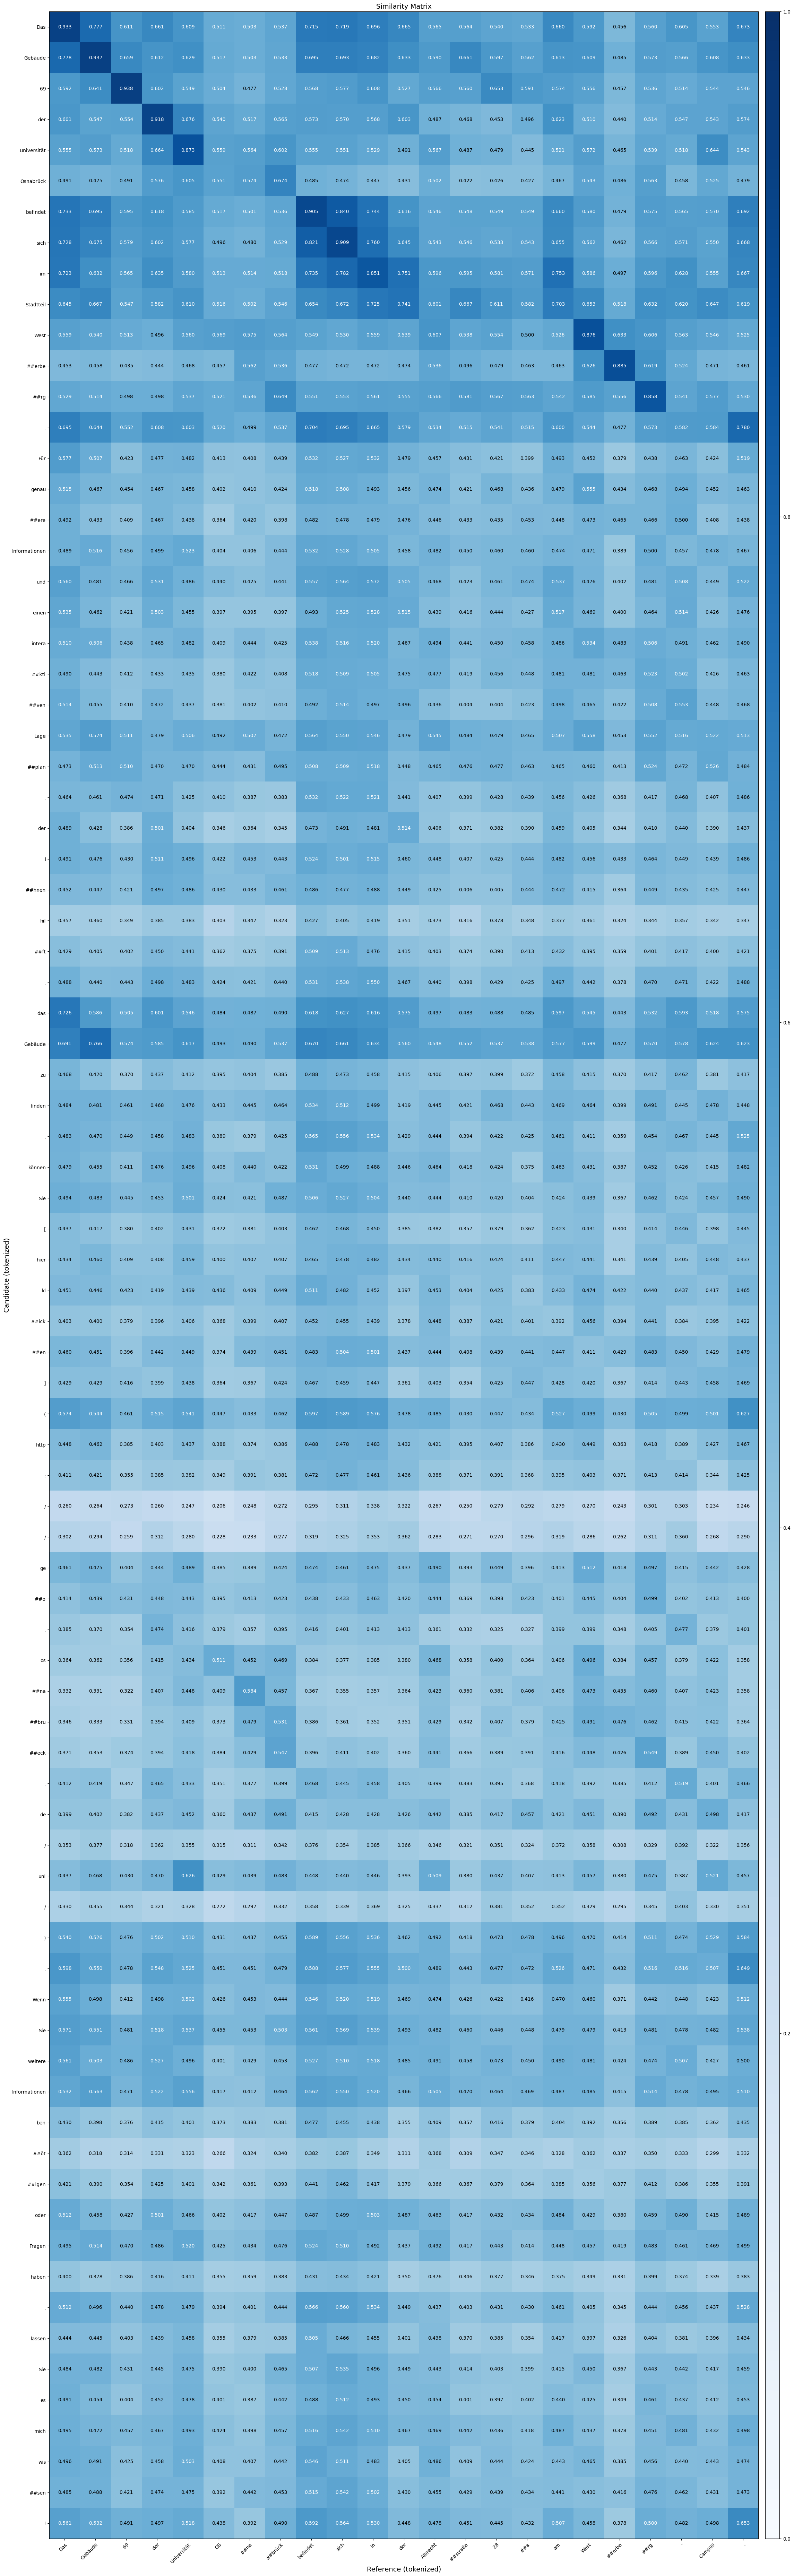

In [13]:
from bert_score import plot_example
import os
cwd = os.getcwd()
pic_path = os.path.join(cwd, 'data/eval/bert_score_example.png')

cand = chatbot_answers_cands[7]
ref = human_answers_refs[7]
plot_example(cand, ref, lang="de", fname=pic_path)